In [1]:
import os
import cdsapi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

In [2]:
#!pip install sdcpy
from tqdm.auto import tqdm
from collections import defaultdict
from sdcpy.scale_dependent_correlation import SDCAnalysis
import warnings

c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Cross-correlation between COVID and climate

In [3]:
world = pd.read_pickle('../data/world_shape.pkl')

In [4]:
country_to_iso = world[['country', 'iso3']].drop_duplicates()

In [5]:
covid_df = pd.read_csv('../data/owd/covid19_world.csv')

In [6]:
dens = pd.read_csv('../data/processed_05_grid.csv')

In [7]:
country_groups = pd.read_csv('../data/country_groups.csv')

In [8]:
lon_lat_country = pd.read_csv('../data/coords_region.csv').merge(country_to_iso)

In [9]:
lon_lat_group = lon_lat_country.merge(country_groups)

In [10]:
processed_path = "../data/climate/processed/"
relevant_files = [f for f in os.listdir(processed_path) if f[:9] < '2022_07_0']
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

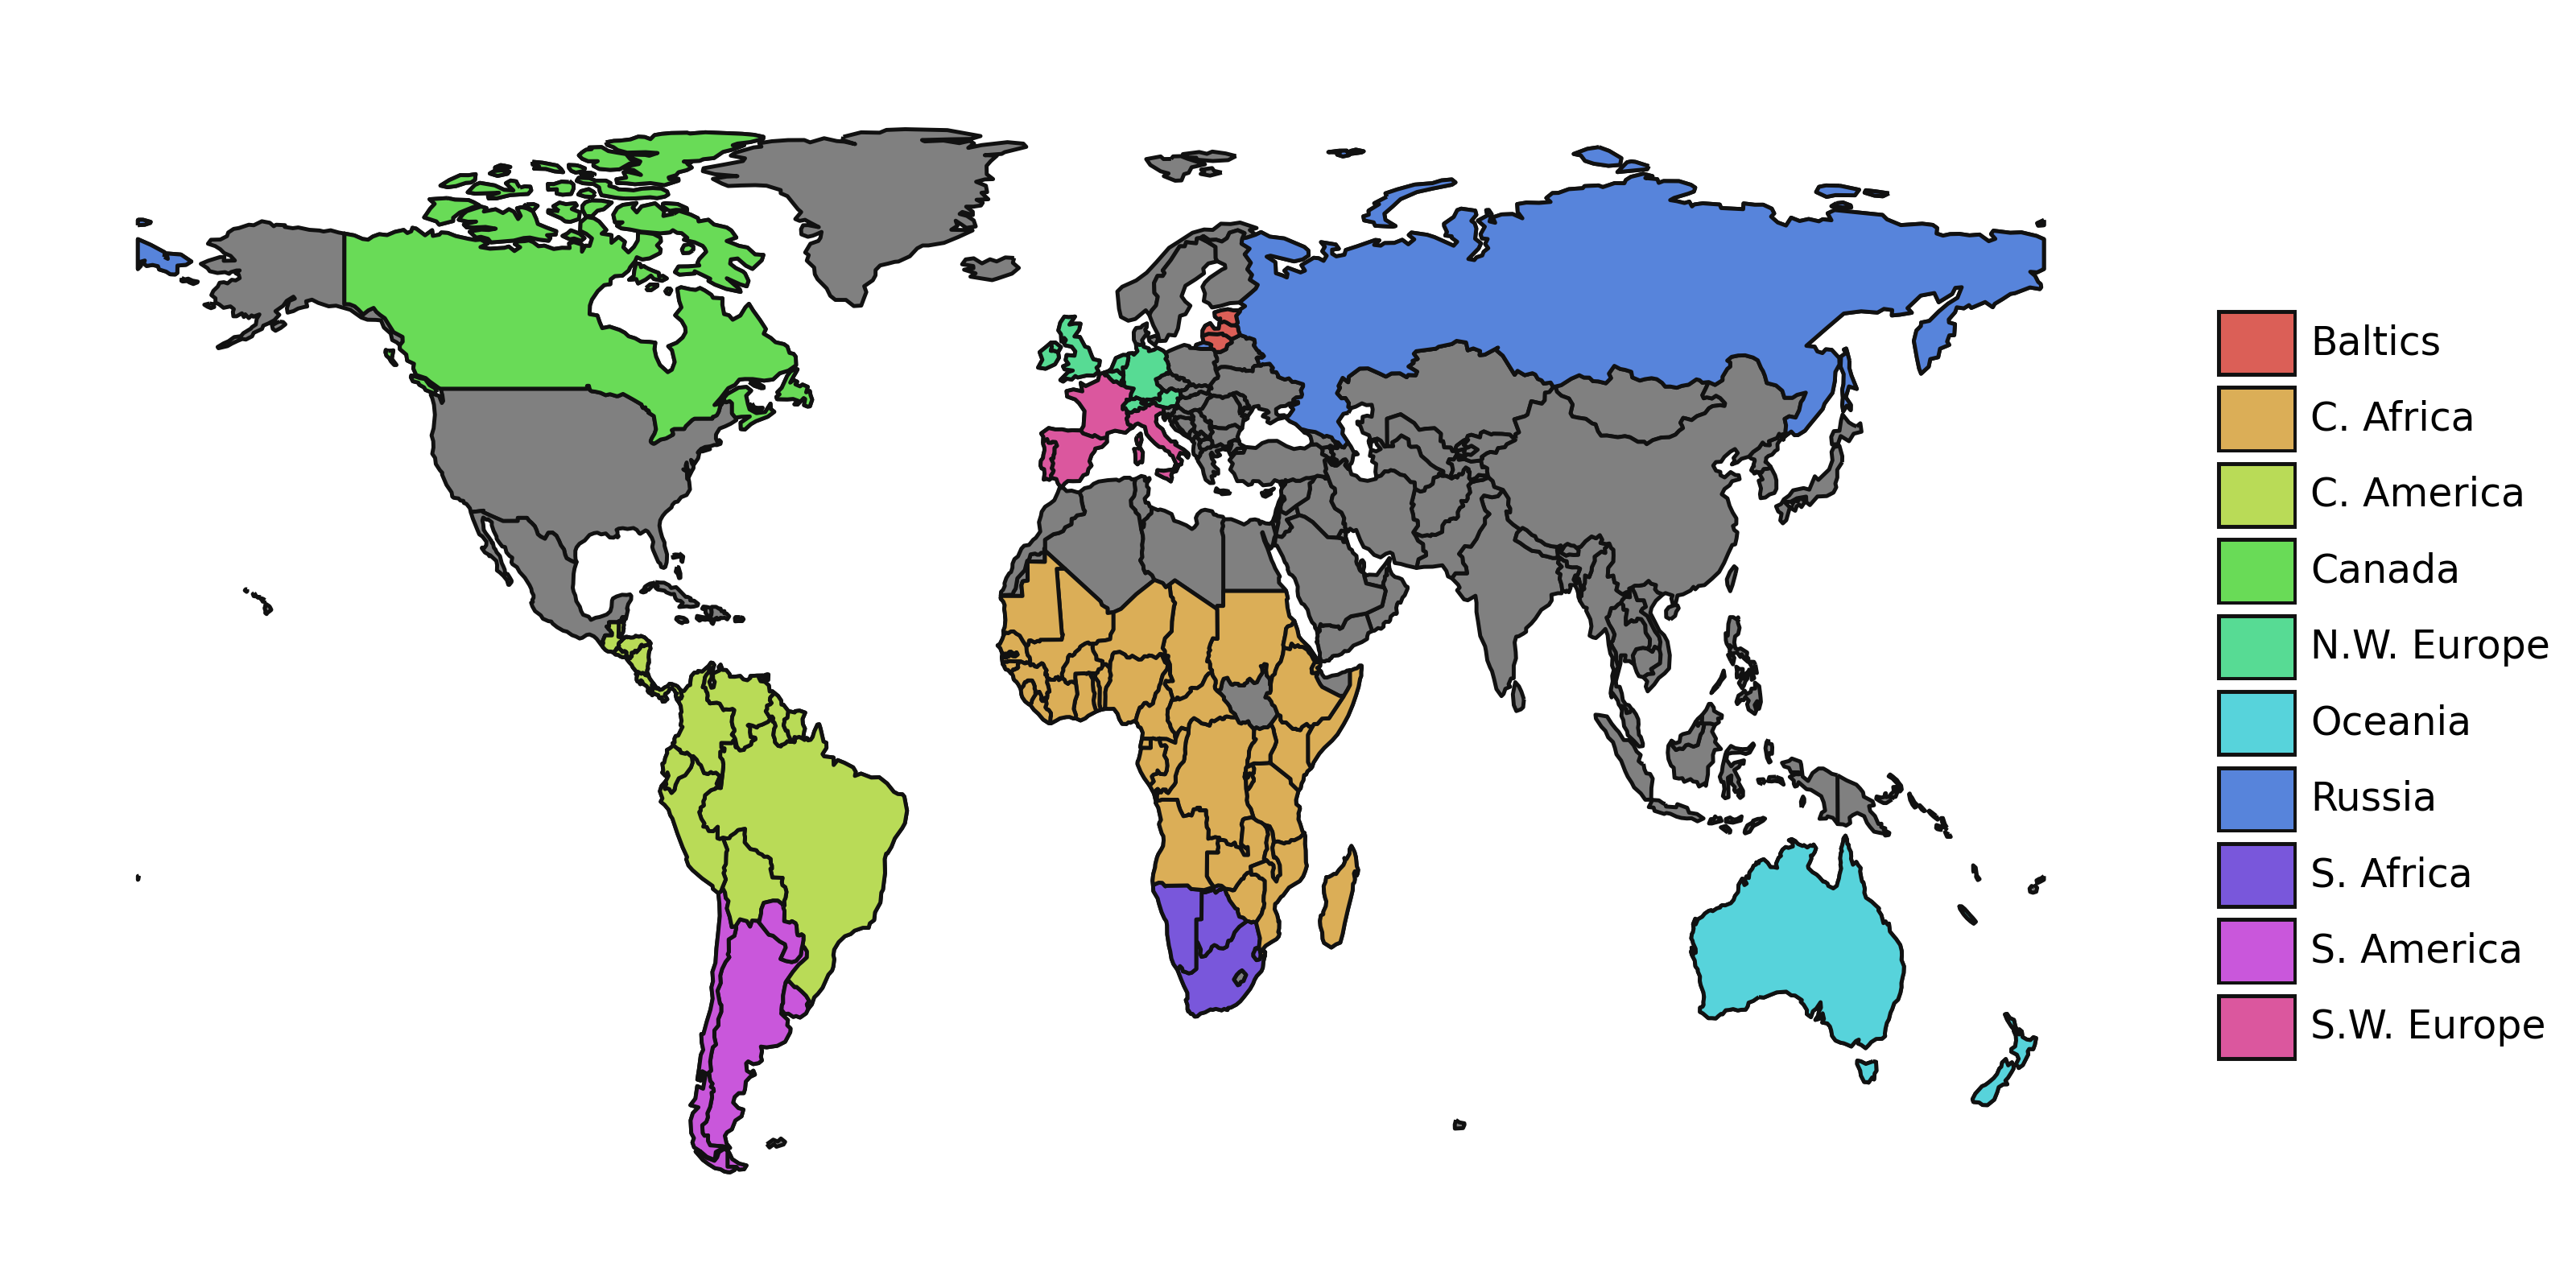

<Figure Size: (1600 x 800)>

In [11]:
f = (world
     .merge(country_groups)
     .pipe(lambda dd: p9.ggplot(dd)
       + p9.geom_map(data=world, fill='gray')
       + p9.geom_map(p9.aes(fill='group'))
       + p9.ylim(-55, None)
       + p9.labs(fill='')
       + p9.theme_void()
       + p9.theme(figure_size=(8, 4), dpi=200, legend_key_height=15)
      )
)
f

In [12]:
weighted_cells = (dens.merge(lon_lat_group)
    .groupby('group', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_46900\1766496956.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [13]:
weighted_climate_df = (
        weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(['group', "date"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [14]:
groups_covid_ts = \
(covid_df
 .merge(country_groups)
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .groupby('group')
 .apply(lambda dd: 
        dd.set_index('date')
        .resample('D')
        .sum()
        ['new_cases']
        #.rolling(center=True, window=7)
        #.mean()
        .loc['2021-01-01': '2022-06-30'])
)

C:\Users\brand\AppData\Local\Temp\ipykernel_46900\374906100.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [15]:
groups_covid_ts

date,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-06-21,2022-06-22,2022-06-23,2022-06-24,2022-06-25,2022-06-26,2022-06-27,2022-06-28,2022-06-29,2022-06-30
group,,,,,,,,,,,,,,,,,,,,,
Baltics,3785.938776,3763.326531,3740.714286,3712.591837,3684.469388,3656.346939,3628.224490,3600.102041,3571.979592,3543.857143,...,528.163265,533.387755,538.612245,543.836735,549.061224,554.285714,625.755102,697.224490,768.693878,840.163265
C. Africa,3488.918367,3515.530612,3542.142857,3897.673469,4253.204082,4608.734694,4964.265306,5319.795918,5675.326531,6030.857143,...,2142.428571,2093.285714,2044.142857,1995.000000,1945.857143,1896.714286,1855.857143,1815.000000,1774.142857,1733.285714
C. America,58345.816327,57596.979592,56848.142857,58649.836735,60451.530612,62253.224490,64054.918367,65856.612245,67658.306122,69460.000000,...,51803.306122,54321.102041,56838.897959,59356.693878,61874.489796,64392.285714,65900.122449,67407.959184,68915.795918,70423.632653
Canada,6862.979592,6981.346939,7099.714286,7216.285714,7332.857143,7449.428571,7566.000000,7682.571429,7799.142857,7915.714286,...,3009.918367,2849.734694,2689.551020,2529.367347,2369.183673,2209.000000,2255.714286,2302.428571,2349.142857,2395.857143
N.W. Europe,83416.387755,85655.265306,87894.142857,89893.306122,91892.469388,93891.632653,95890.795918,97889.959184,99889.122449,101888.285714,...,99463.489796,104477.020408,109490.551020,114504.081633,119517.612245,124531.142857,127013.530612,129495.918367,131978.306122,134460.693878
Oceania,31.102041,31.693878,32.285714,30.775510,29.265306,27.755102,26.244898,24.734694,23.224490,21.714286,...,32545.122449,33132.183673,33719.244898,34306.306122,34893.367347,35480.428571,31166.938776,26853.448980,22539.959184,18226.469388
Russia,27274.224490,26961.326531,26648.428571,26212.265306,25776.102041,25339.938776,24903.775510,24467.612245,24031.448980,23595.285714,...,3053.204082,3031.734694,3010.265306,2988.795918,2967.326531,2945.857143,2951.102041,2956.346939,2961.591837,2966.836735
S. Africa,13573.673469,13822.122449,14070.571429,14698.612245,15326.653061,15954.693878,16582.734694,17210.775510,17838.816327,18466.857143,...,1922.775510,1817.734694,1712.693878,1607.653061,1502.612245,1397.571429,1269.877551,1142.183673,1014.489796,886.795918
S. America,11642.367347,11988.183673,12334.000000,12955.755102,13577.510204,14199.265306,14821.020408,15442.775510,16064.530612,16686.285714,...,15364.265306,15121.469388,14878.673469,14635.877551,14393.081633,14150.285714,14230.367347,14310.448980,14390.530612,14470.612245


In [16]:
groups_weather_ts = \
(weighted_climate_df
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .query('"2021-01-01" <= date <= "2022-06-30"')
 .set_index(['group', 'date'])
)

In [17]:
groups_weather_ts

temperature  absolute_humidity
group       date                                      
Baltics     2021-01-01    -0.142261           4.563512
            2021-01-02    -0.036603           4.451540
            2021-01-03    -0.352534           4.340192
            2021-01-04    -0.572753           4.153843
            2021-01-05     0.030254           4.403363
...                             ...                ...
S.W. Europe 2022-06-26    21.697848          13.379089
            2022-06-27    22.037619          13.302471
            2022-06-28    22.161416          13.586848
            2022-06-29    22.079749          14.155224
            2022-06-30    21.147643          13.928244

[5460 rows x 2 columns]

In [18]:
groups_weather_ts.loc['Baltics']['temperature']

date
2021-01-01    -0.142261
2021-01-02    -0.036603
2021-01-03    -0.352534
2021-01-04    -0.572753
2021-01-05     0.030254
                ...    
2022-06-26    23.592120
2022-06-27    24.290217
2022-06-28    24.397175
2022-06-29    22.345282
2022-06-30    23.027119
Name: temperature, Length: 546, dtype: float64

In [19]:
groups_covid_ts.loc['Baltics']

date
2021-01-01    3785.938776
2021-01-02    3763.326531
2021-01-03    3740.714286
2021-01-04    3712.591837
2021-01-05    3684.469388
                 ...     
2022-06-26     554.285714
2022-06-27     625.755102
2022-06-28     697.224490
2022-06-29     768.693878
2022-06-30     840.163265
Freq: D, Name: Baltics, Length: 546, dtype: float64

In [20]:
CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

In [21]:
import openpyxl

w = 75
out_dir = '../results'
for group in tqdm(country_groups.group.unique(), desc='Processing Groups', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        covid_ts = groups_covid_ts.loc[group]
        weather_ts = groups_weather_ts.loc[group][weather_variable]
        sdc = SDCAnalysis(ts1=weather_ts,
                          ts2=covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plot(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {group} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {group}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.pdf")